In [1]:
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

In [2]:
# Parent directory for the results of this run
group_results_directory = '/data/jpetrie/MEOPAR/SalishSea/results/nampismort_june_15_old_IC/' + '/'
tracer_file = 'SS5x5_1h_20150201_20150501_ptrc_T.nc'
mesh_mask_file = 'mesh_mask.nc'
individual_directories = []
param_vals = []
param_name = "nampismort_zz_rate_pico_rm"

for file in os.listdir(group_results_directory):
    if os.path.isfile(group_results_directory + file + '/' + tracer_file):
        last_underscore = file.rfind("_")
        file_param_name = file[:last_underscore]
        if file_param_name == param_name:
            val = float(file[(last_underscore + 1):])
            individual_directories.append(file)
            param_vals.append(val)

tracer_datasets = [xr.open_dataset(group_results_directory + '/' + file +'/' + tracer_file) for file in individual_directories]
dataset_dict = dict(zip(param_vals, tracer_datasets))

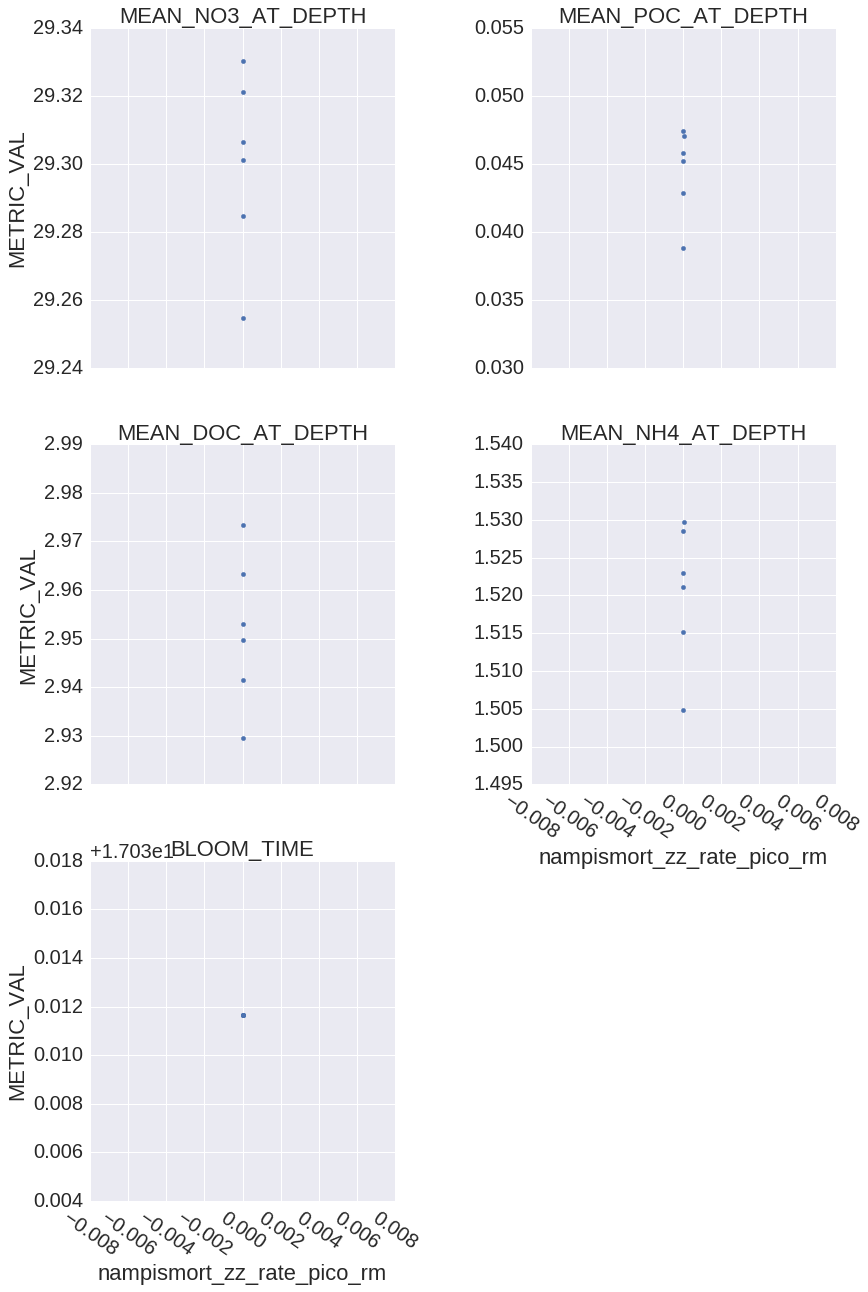

In [3]:
sns.set(font_scale = 2)
plt.rcParams['image.cmap'] = 'jet'
depths = dataset_dict[param_vals[0]].deptht.values

min_depth_index = np.argmax(depths > 150)
max_depth_index = len(depths)

t = np.array([float(x) for x in dataset_dict[param_vals[0]].time_centered.values])   
days = (t[:] - t[0])/10**9/3600/24

min_day_index = np.argmax(days > 30)
max_day_index = len(days)

mesh_mask = xr.open_dataset(group_results_directory + individual_directories[0] + '/' + mesh_mask_file)
grid_heights = np.array(mesh_mask['e3t_1d'][0])

param_metrics = pd.DataFrame()


plot_tracers = ['NO3', 'POC', 'DOC', 'NH4']

for param in param_vals:
    for tracer in plot_tracers:
        tracer_quantity_array = ((dataset_dict[param][tracer].values)*(grid_heights.reshape((1,40,1,1))))
        total_tracer_at_depth = tracer_quantity_array[min_day_index:max_day_index, min_depth_index:max_depth_index,:,:].sum()
        mean_tracer = total_tracer_at_depth/sum(grid_heights[min_depth_index:max_depth_index])/(max_day_index - min_day_index)/15
        param_metrics = param_metrics.append(pd.DataFrame({param_name:[param], "METRIC_NAME":['MEAN_'+tracer + "_AT_DEPTH"], "METRIC_VAL": [mean_tracer]}))

    phy2_qunatity_array = ((dataset_dict[param]["PHY2"].values)*(grid_heights.reshape((1,40,1,1))))
    phy2_qunatity_array.sum((0,3)).shape
    total_phy2 = phy2_qunatity_array.sum((1,2,3))
    bloom_time = days[np.argmax(total_phy2)]
    param_metrics = param_metrics.append(pd.DataFrame({param_name:[param], "METRIC_NAME":["BLOOM_TIME"], "METRIC_VAL": [bloom_time]}))

   
fg = sns.FacetGrid(data=param_metrics, col = "METRIC_NAME",  sharey=False, col_wrap = 2, size = 6)
fg.map(plt.scatter, param_name, "METRIC_VAL").add_legend()
fg.set_xticklabels(rotation=-35)
fg.set_titles("{col_name}")

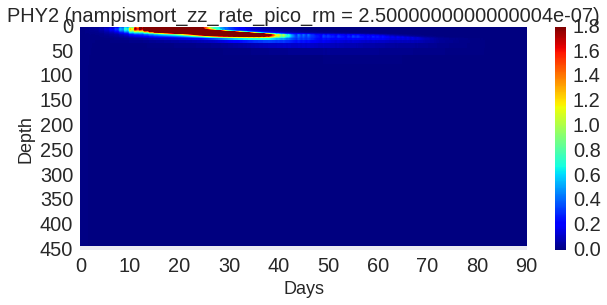

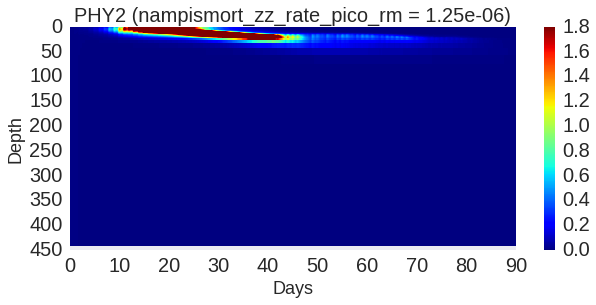

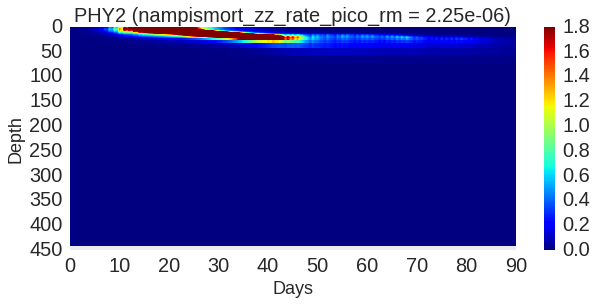

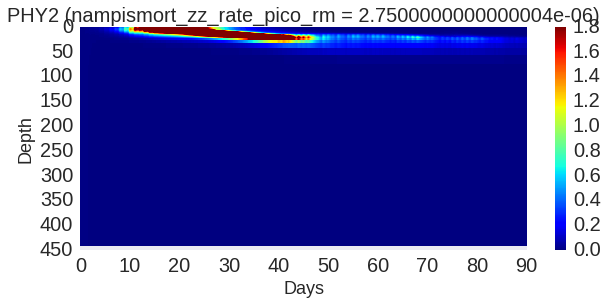

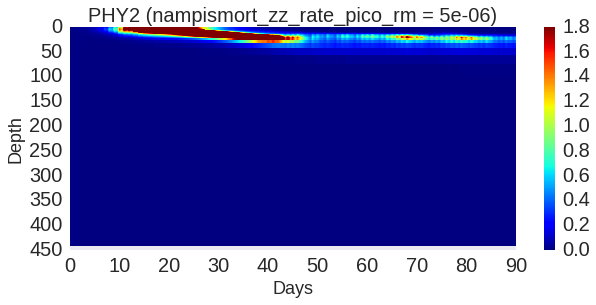

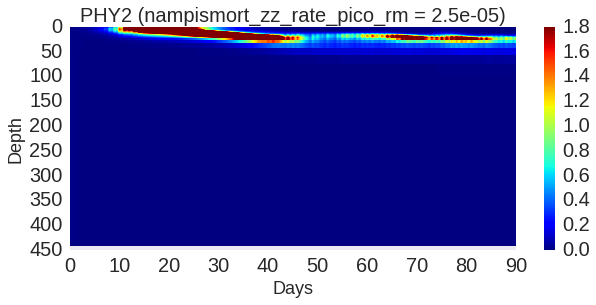

In [4]:
# Plot depth/time/DON heatmap for each value of alpha
tracer = "PHY2"


keys = (list(dataset_dict.keys()))
keys.sort()

for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0,vmax = 1.8)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer +  " (" + param_name + " = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

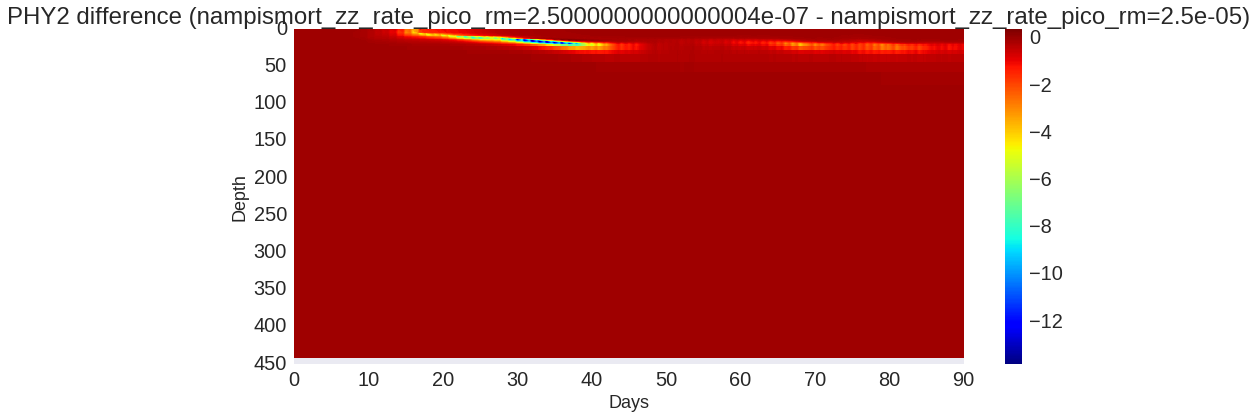

In [5]:
# Plot the difference in DON concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)
mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (" + param_name + "=" + str(param_1) + " - " + param_name + "=" +str(param_2)+ ")")

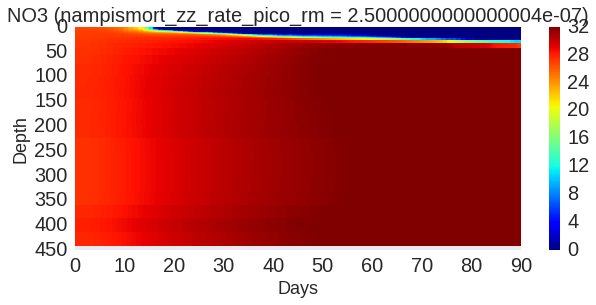

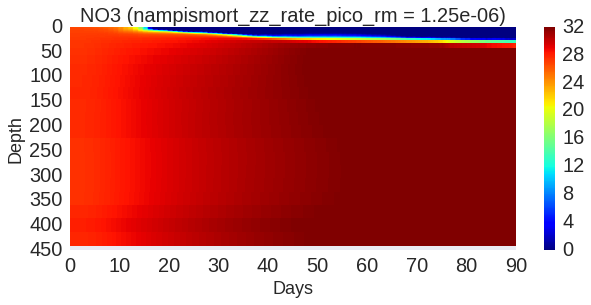

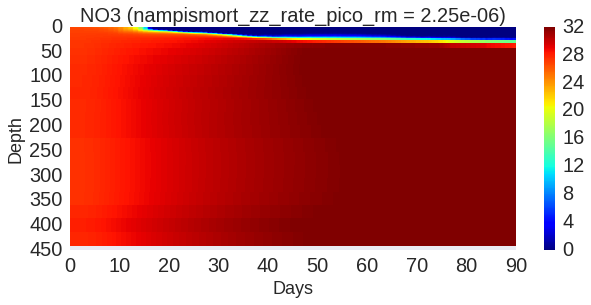

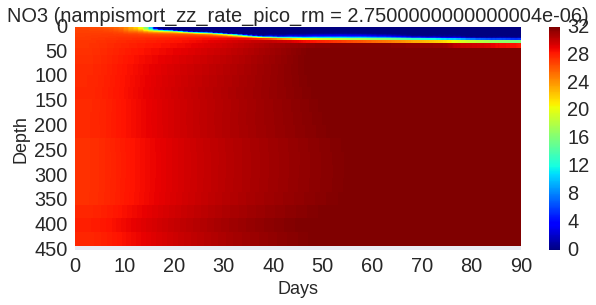

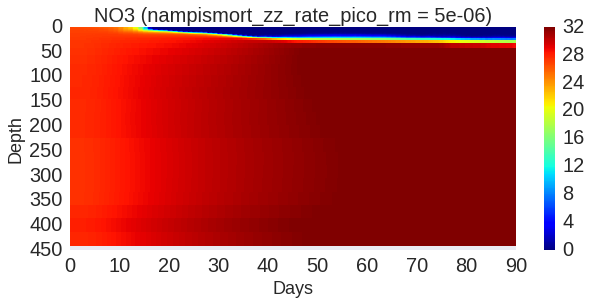

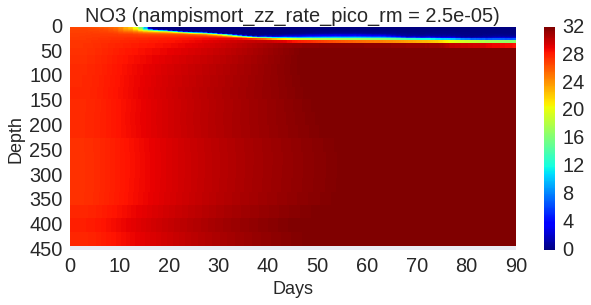

In [6]:
# Plot depth/time/NO3 heatmap for each value
tracer = "NO3"


for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0, vmax = 32)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer + " (" + param_name + " = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

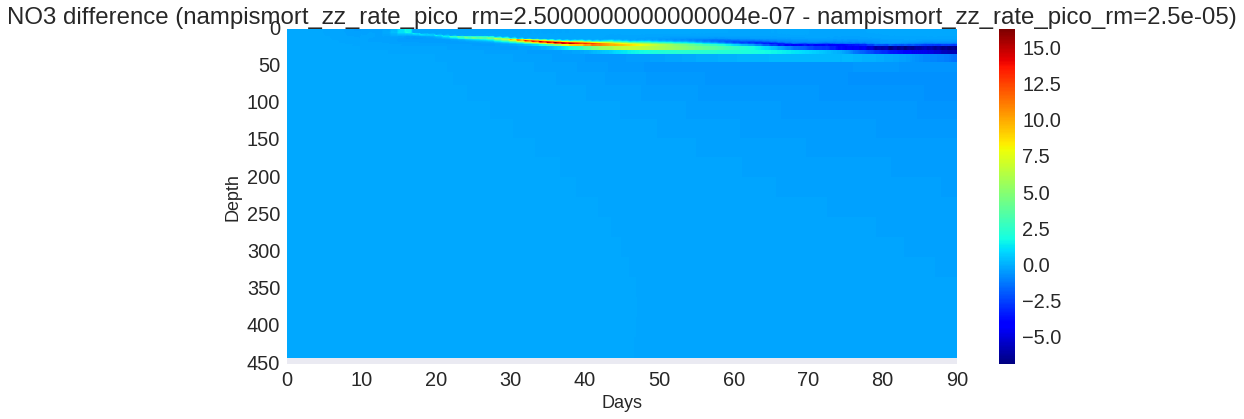

In [7]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (" + param_name + "=" + str(param_1) + " - " + param_name + "=" +str(param_2)+ ")")

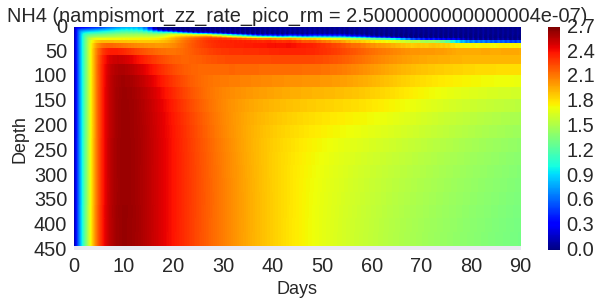

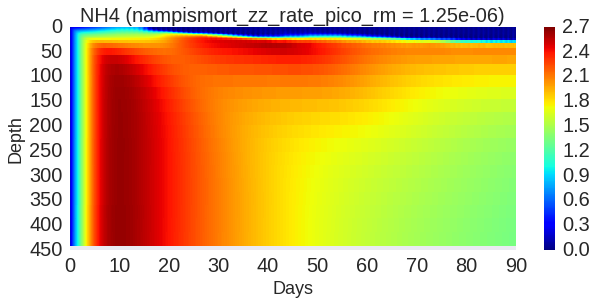

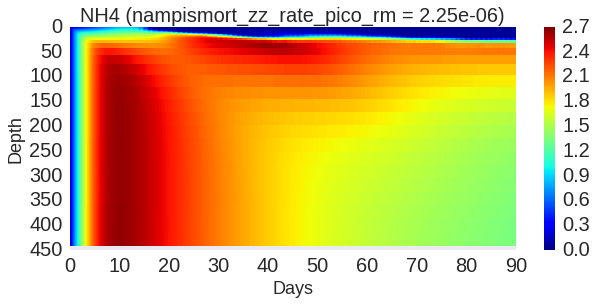

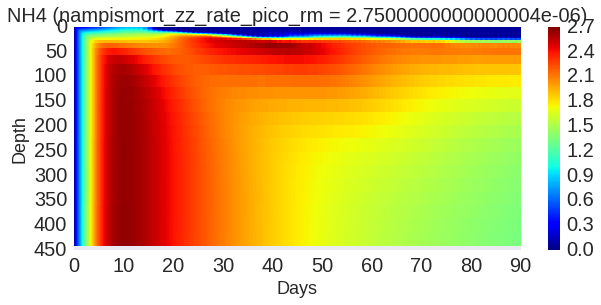

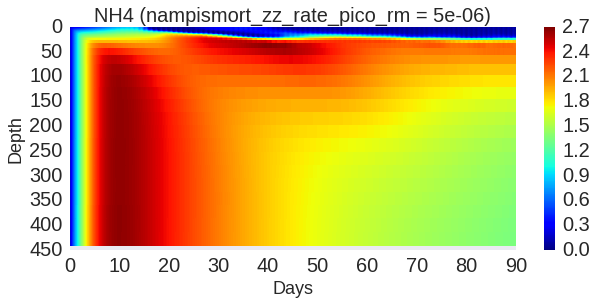

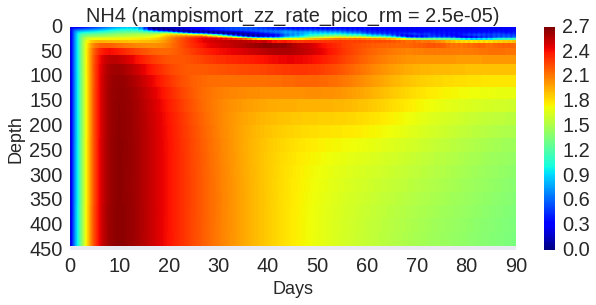

In [8]:
# Plot depth/time/DON heatmap for each value of alpha
tracer = "NH4"


keys = (list(dataset_dict.keys()))
keys.sort()

for param_val in keys:
    z = dataset_dict[param_val].deptht.values
    t= np.array([float(x) for x in dataset_dict[param_val].time_centered.values])
    tz,zt=np.meshgrid((t[:] - t[0])/10**9/3600/24,z[:])
    
    fig, ax = plt.subplots(1, 1,figsize=(10,4))
    mesh=plt.pcolormesh(tz,zt,dataset_dict[param_val][tracer].values[:,:,2,2].T, vmin = 0,vmax = 2.7)
    fig.colorbar(mesh)
    plt.gca().invert_yaxis()
    plt.title(tracer +  " (" + param_name + " = " + str(param_val)+")", size = 20)
    plt.xlabel("Days", size =18)
    plt.ylabel("Depth", size = 18)

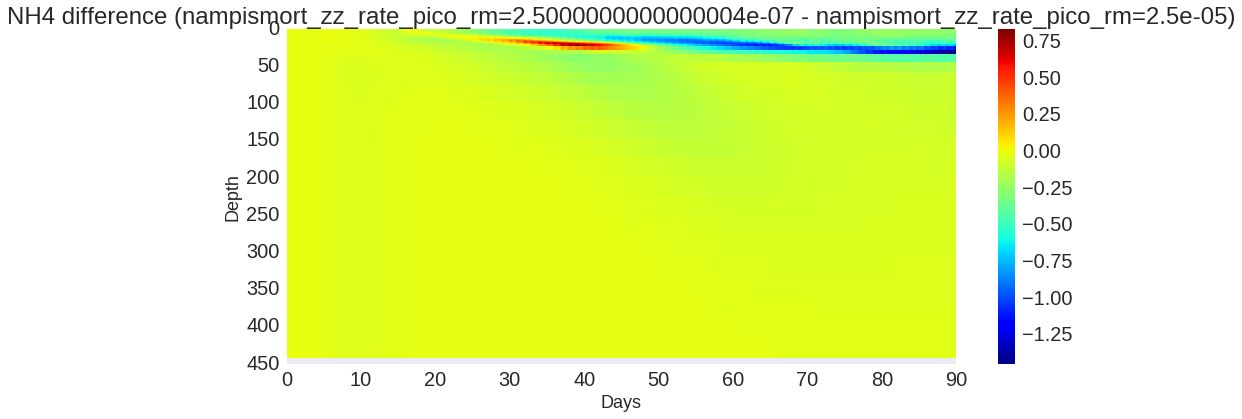

In [9]:
# Plot the difference in NO3 concentration vs depth and time
fig, ax = plt.subplots(1, 1,figsize=(15,6))
param_1 = min(param_vals)
param_2 = max(param_vals)

mesh=plt.pcolormesh(tz,zt,dataset_dict[param_1][tracer].values[:,:,2,2].T - dataset_dict[param_2][tracer].values[:,:,2,2].T)
fig.colorbar(mesh)
plt.gca().invert_yaxis()
plt.xlabel("Days", size =18)
plt.ylabel("Depth", size = 18)
plt.title(tracer + " difference (" + param_name + "=" + str(param_1) + " - " + param_name + "=" +str(param_2)+ ")")

In [10]:
# Convert list of xarrays to a single pandas dataframe. Easier to manipulate and plot
dataframe_list = []
for param_val in keys:
    df = dataset_dict[param_val].to_dataframe().query('x == 2 and y == 2 and axis_nbounds == 0')
    df[param_name] = param_val
    dataframe_list.append(df)

df_subset = pd.concat(dataframe_list)

df_subset.reset_index(inplace=True) # Get rid of that multiindex madness

In [11]:
plot_vars = [ 'DOC','MICZ', 'MYRI', 'NH4', 'NO3', 'O2', 'PHY', 'PHY2', 'POC', 'Si', 'bSi']

[   0.5000003    15.63428783   98.06295776  306.834198  ]


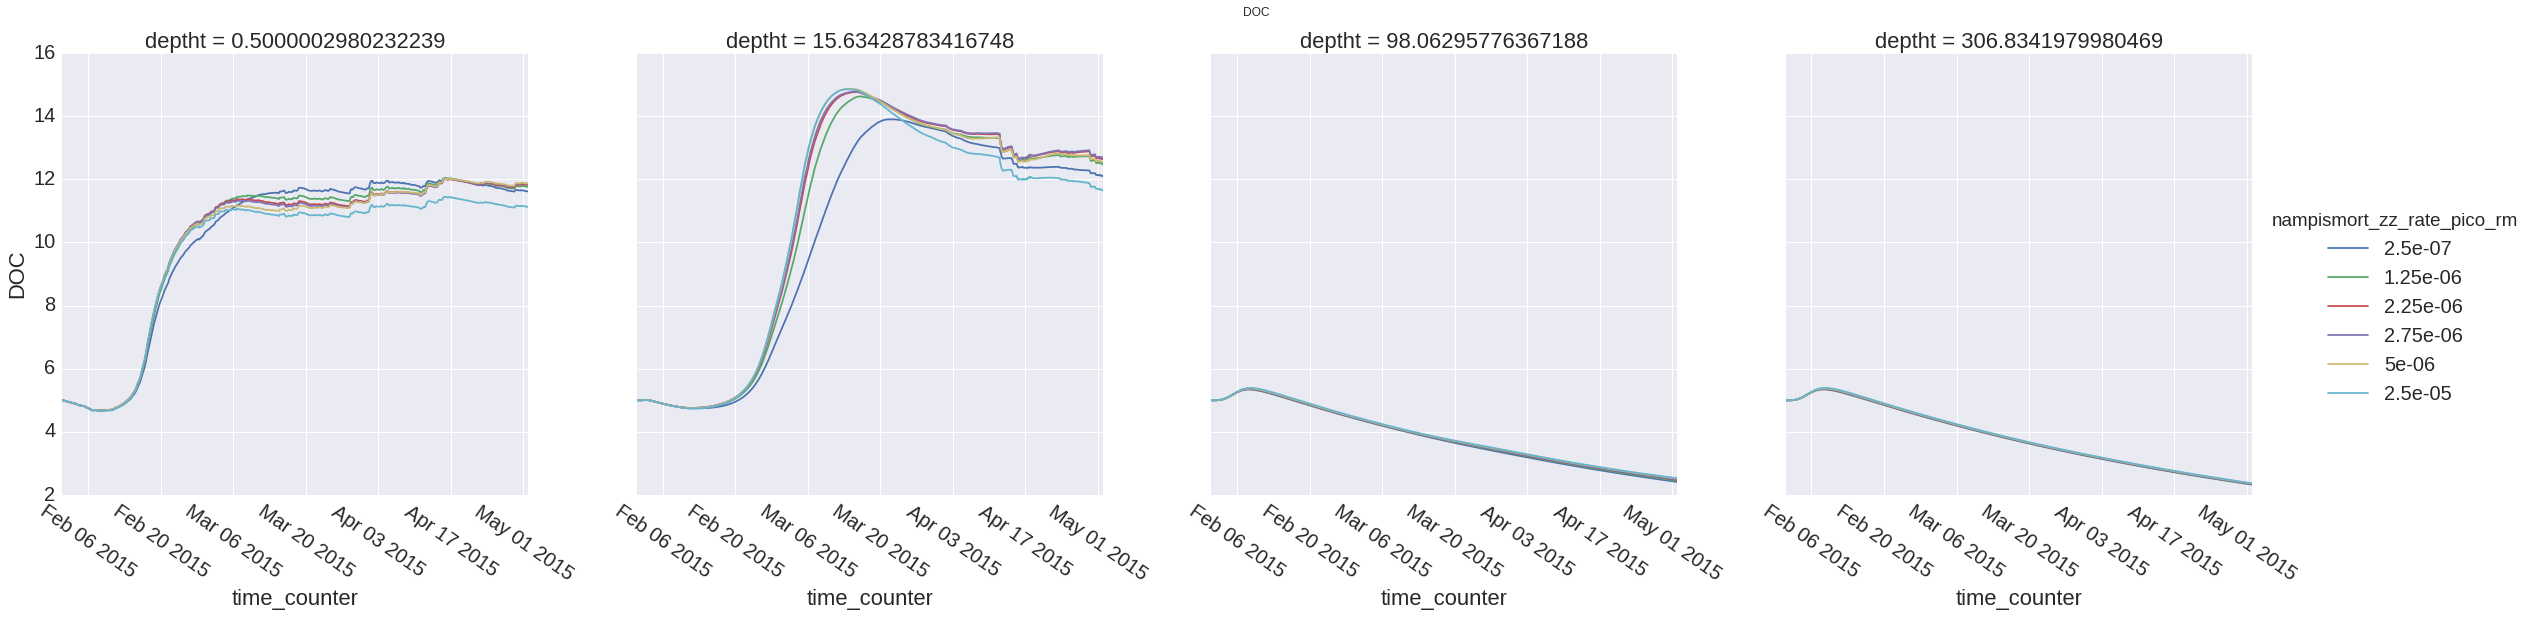

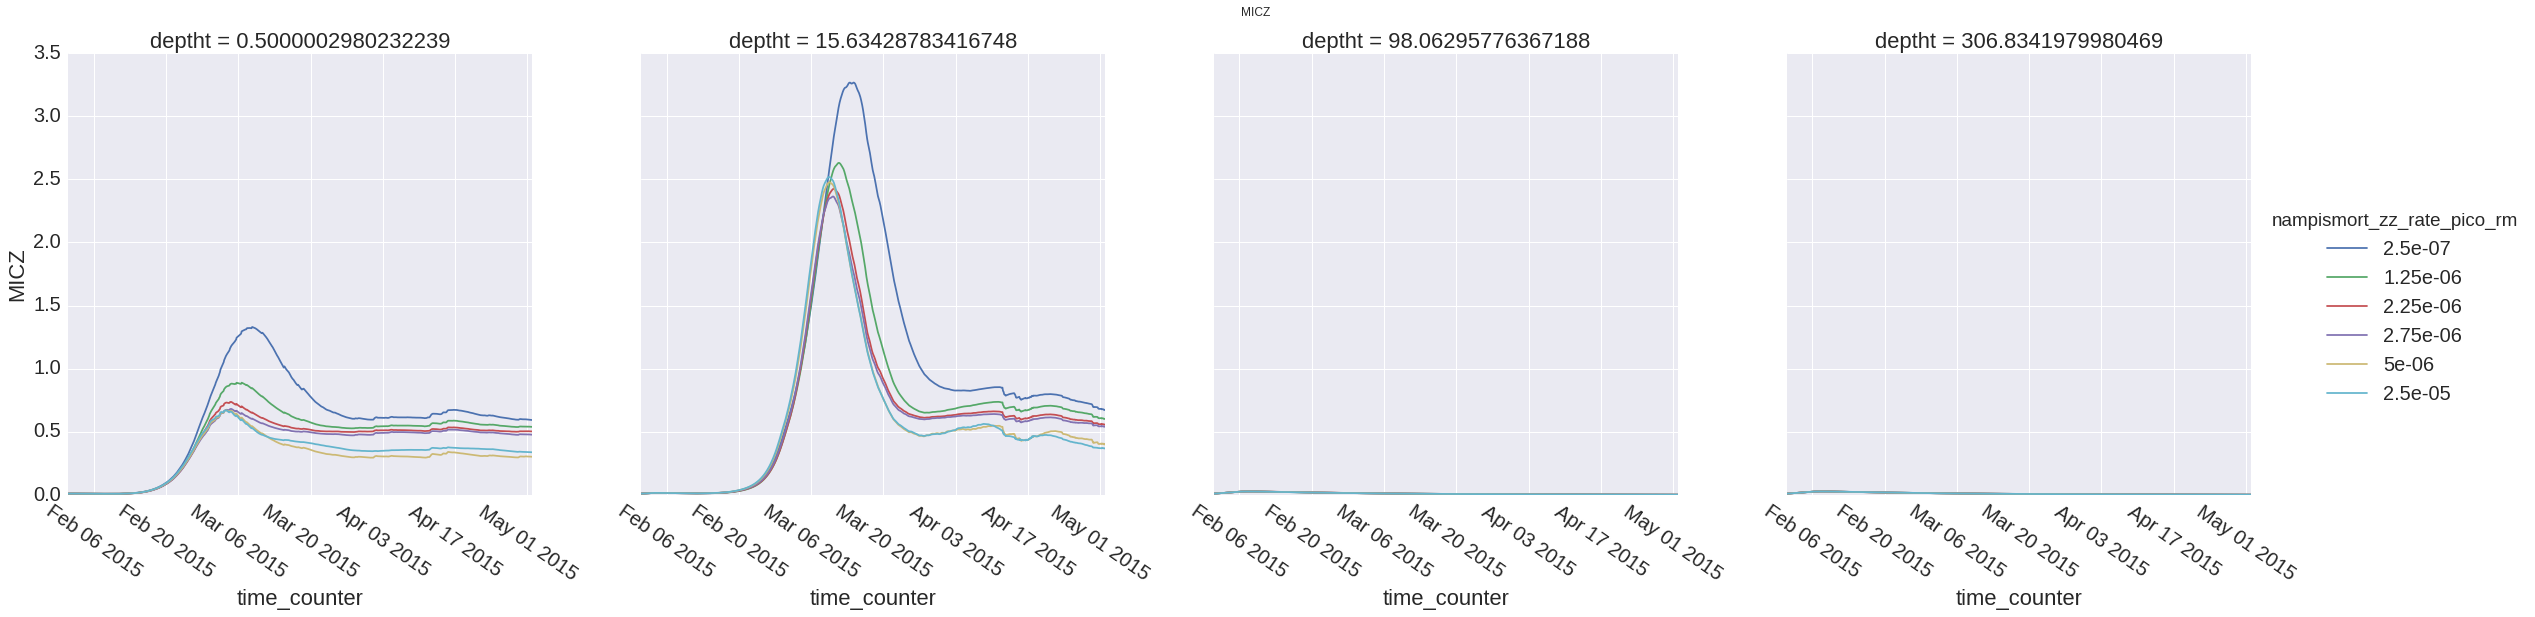

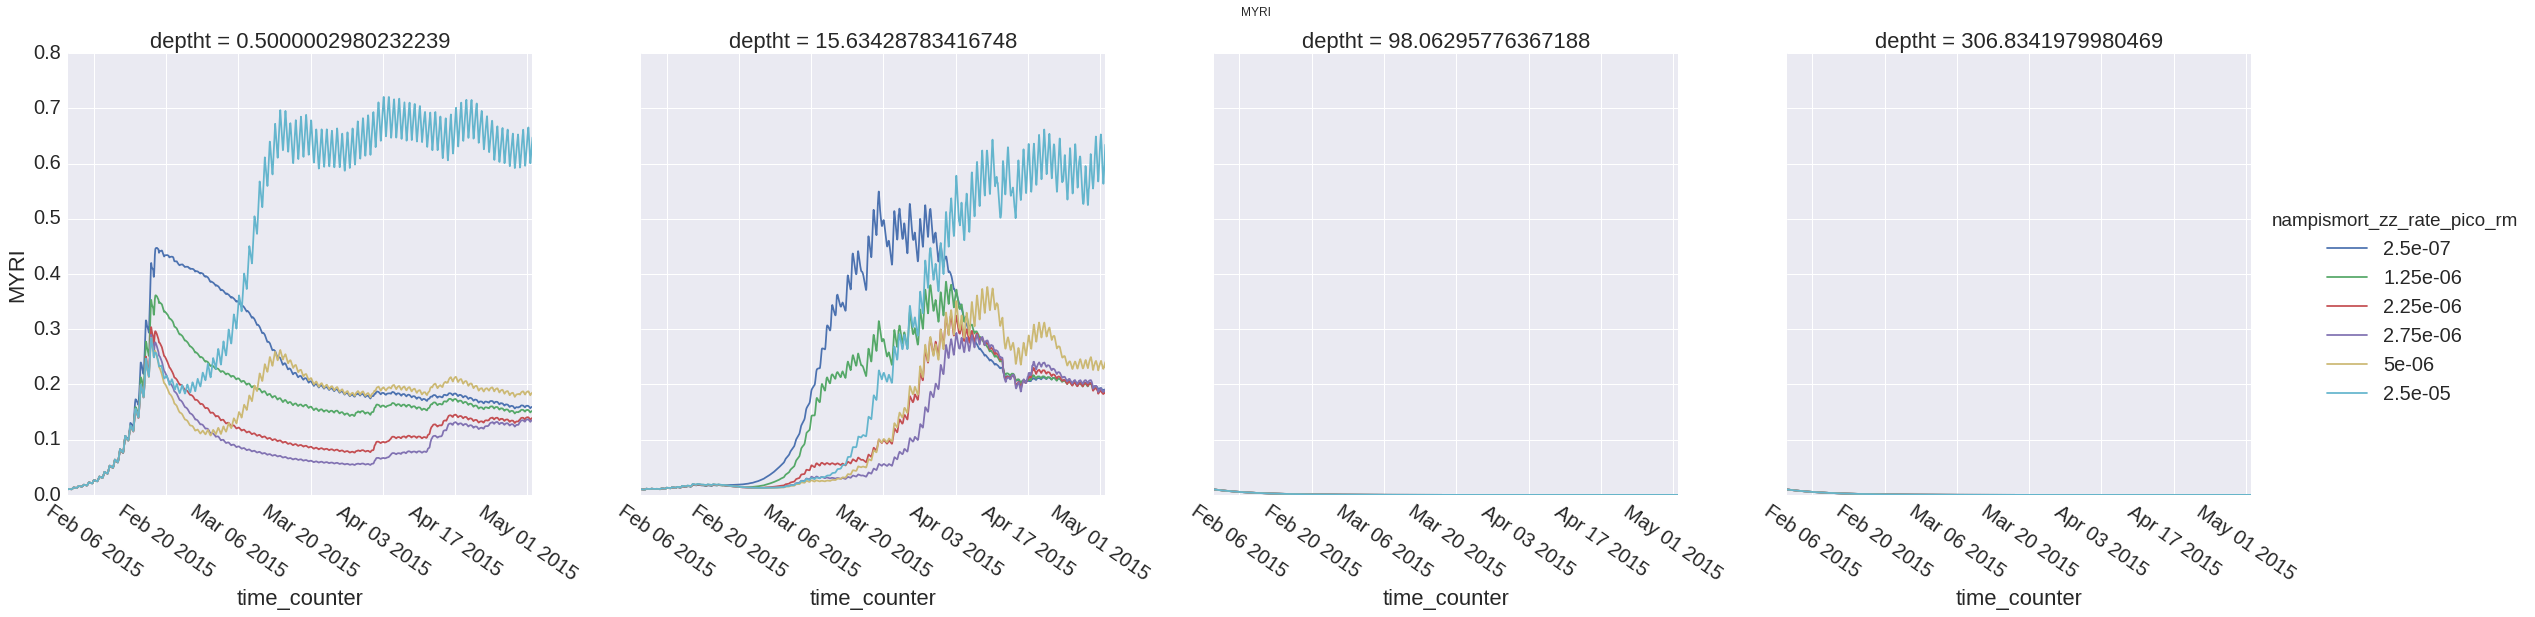

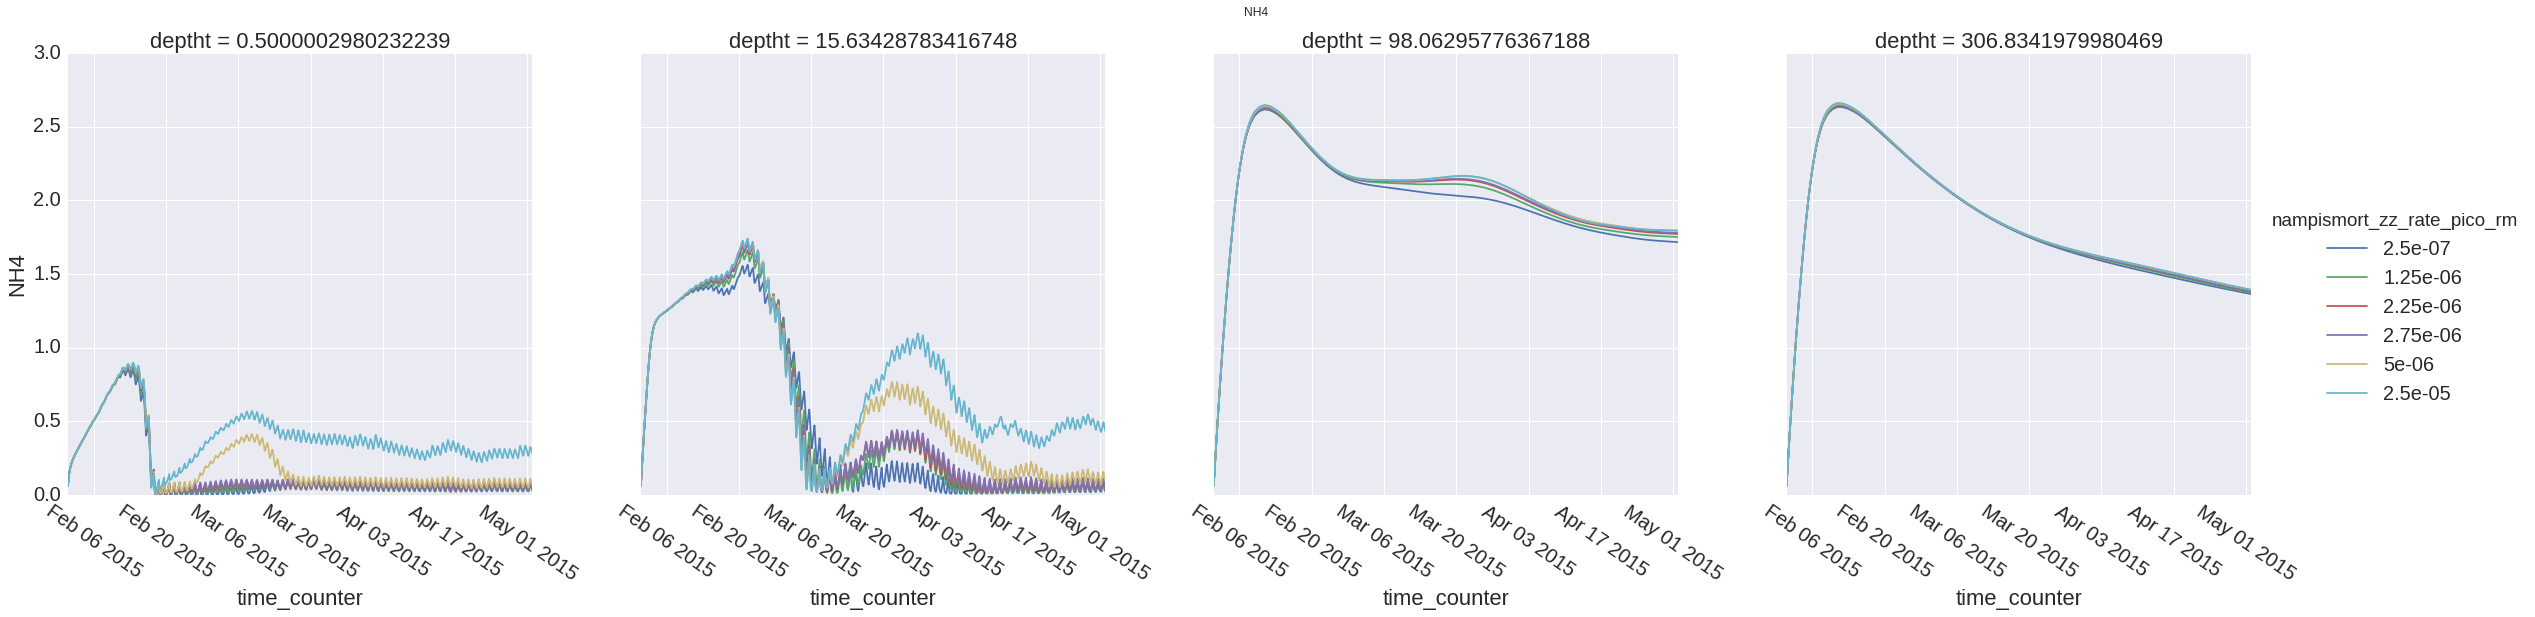

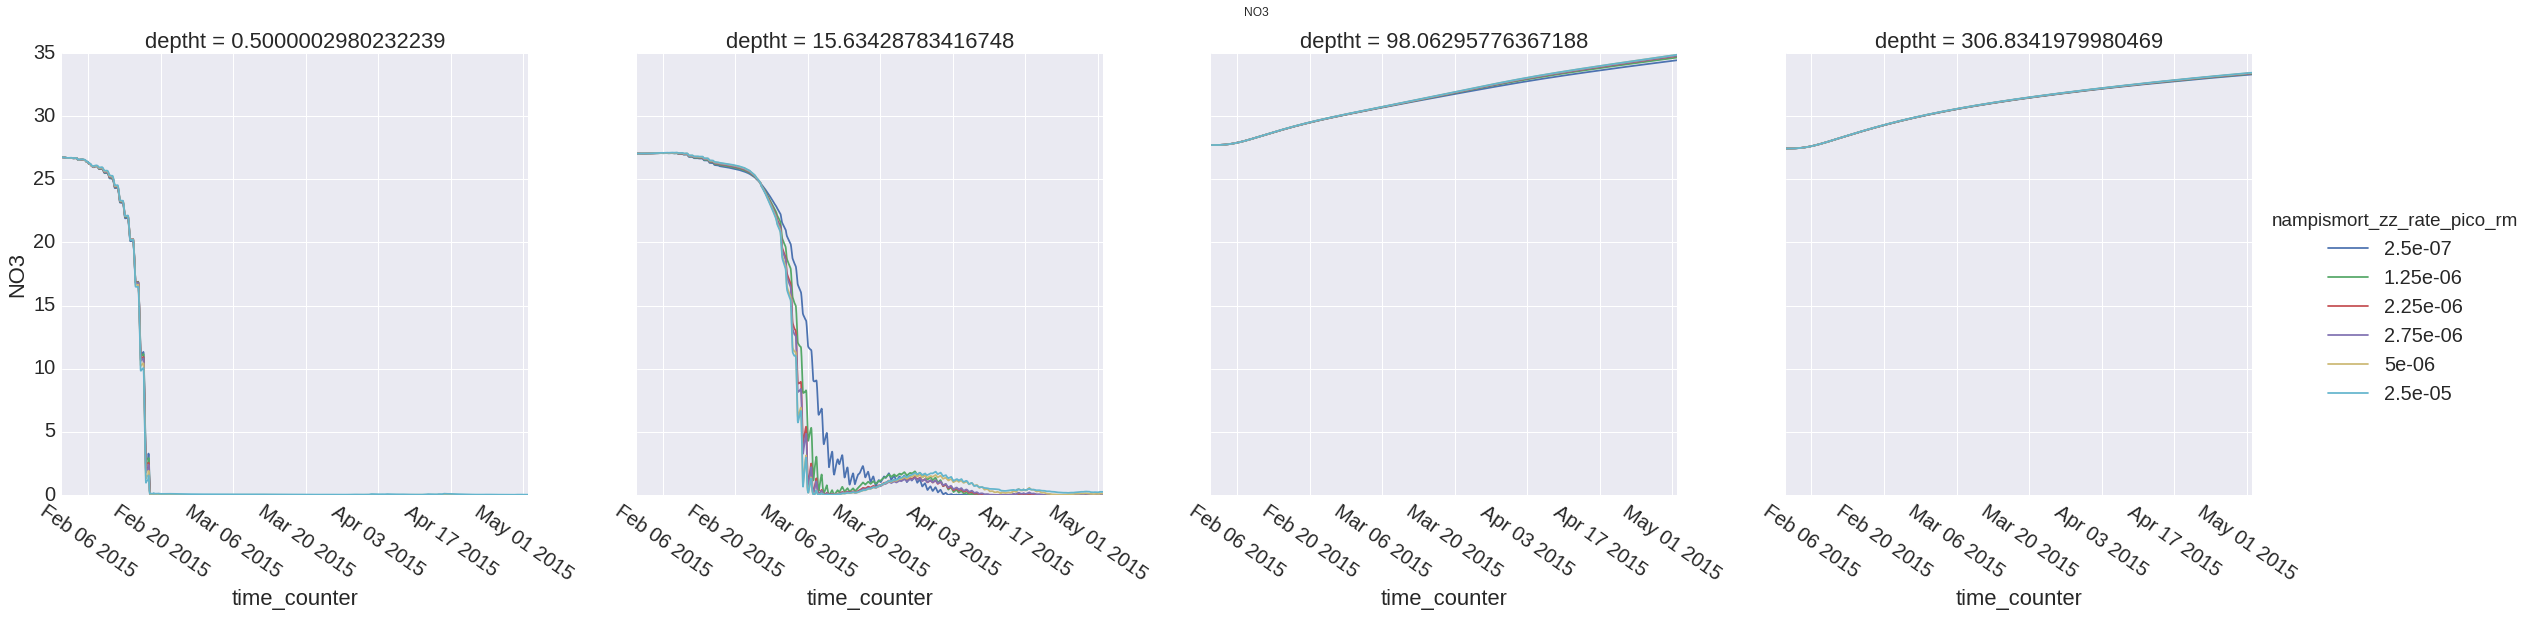

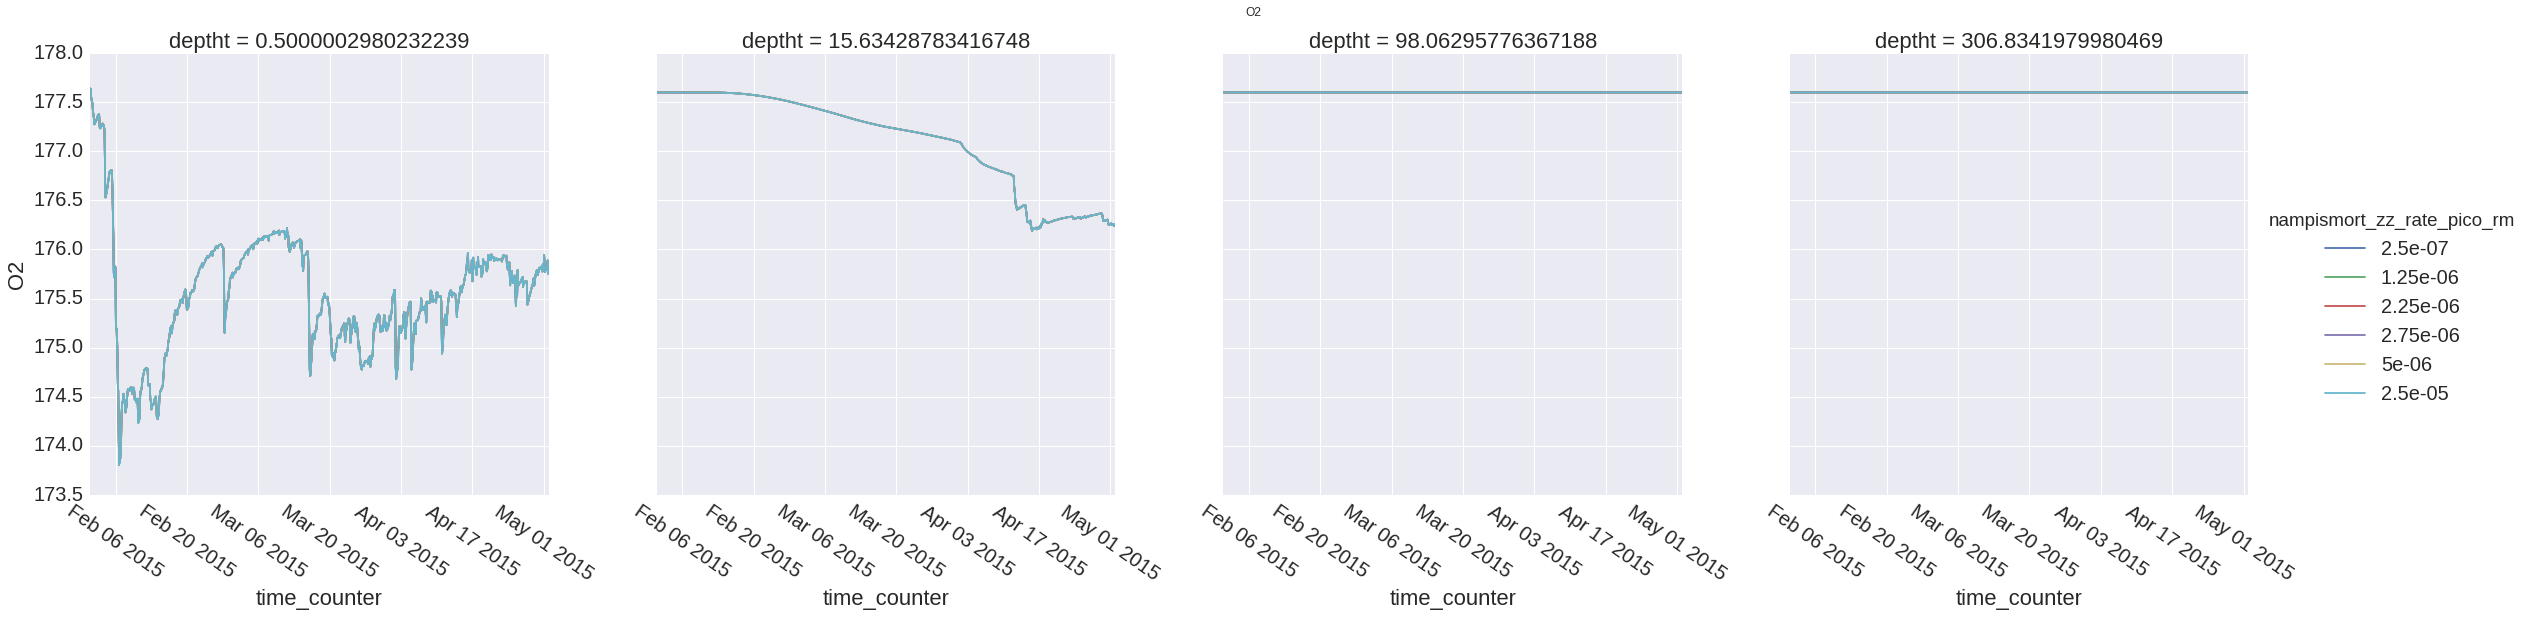

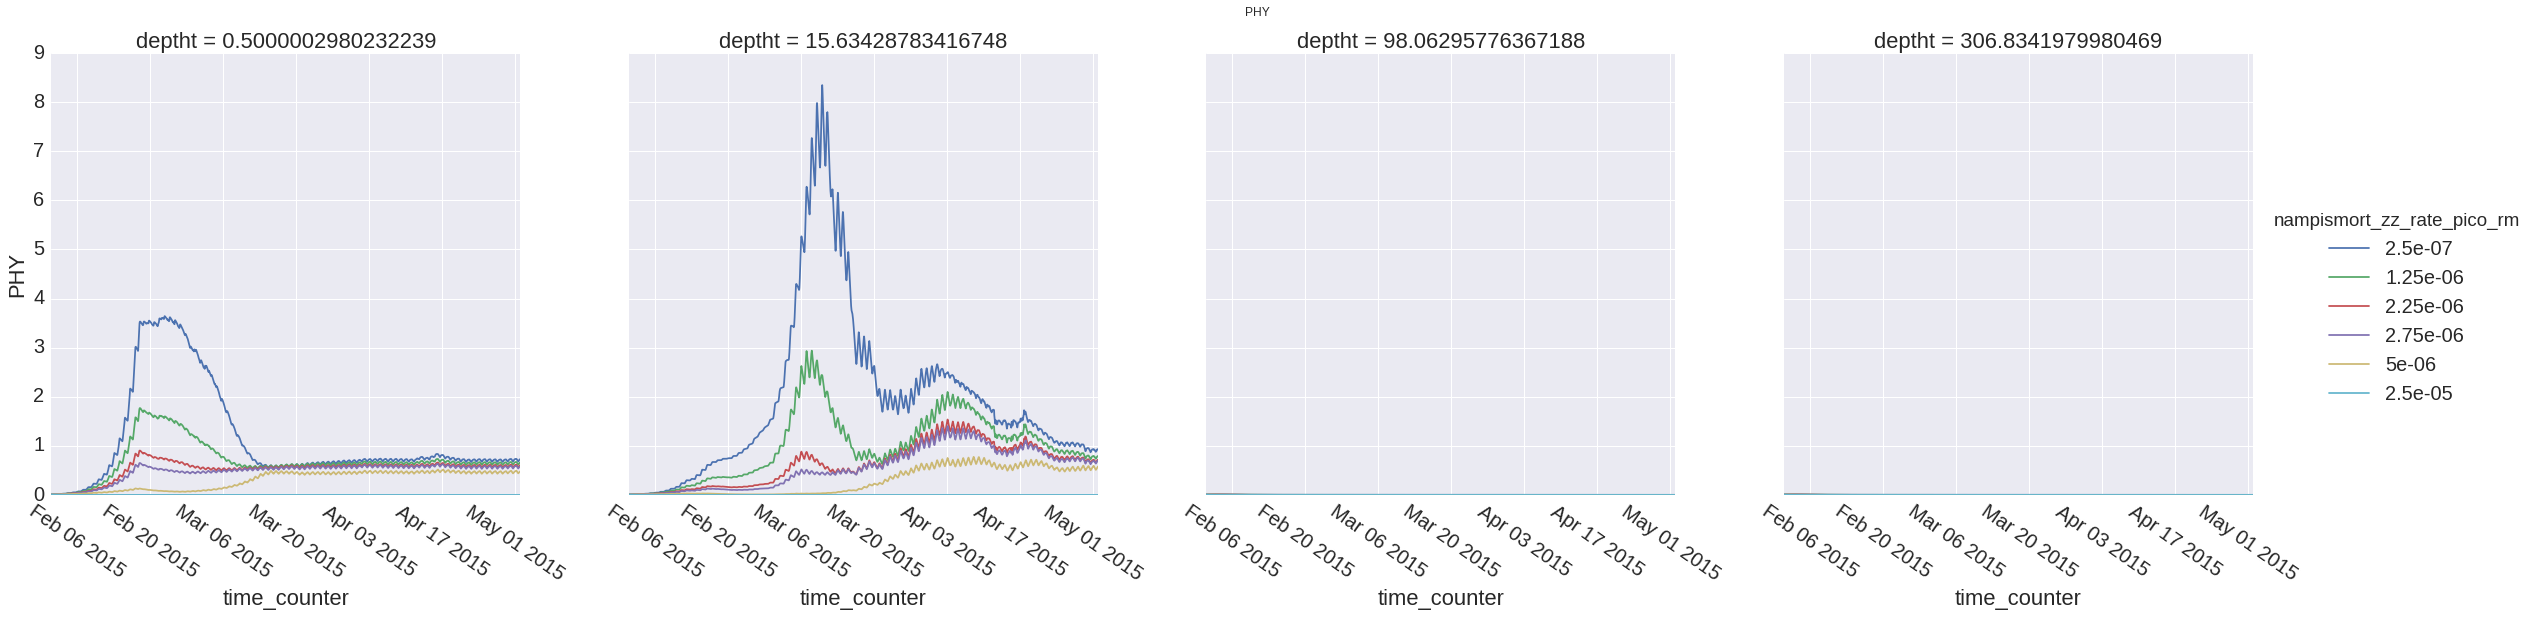

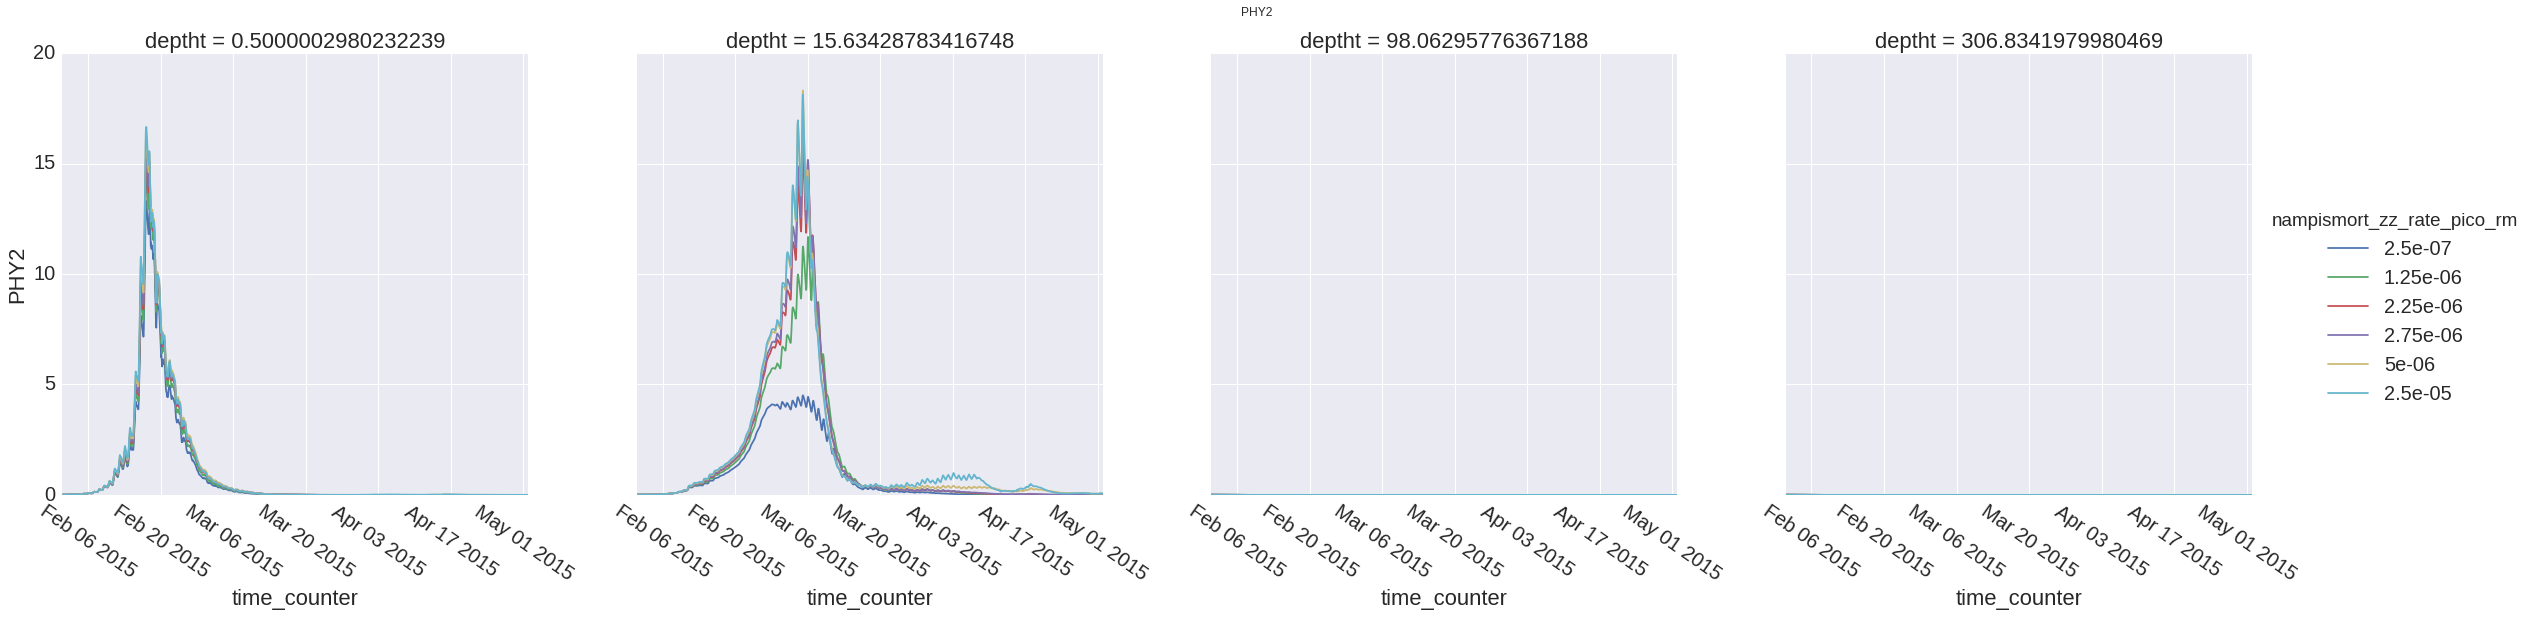

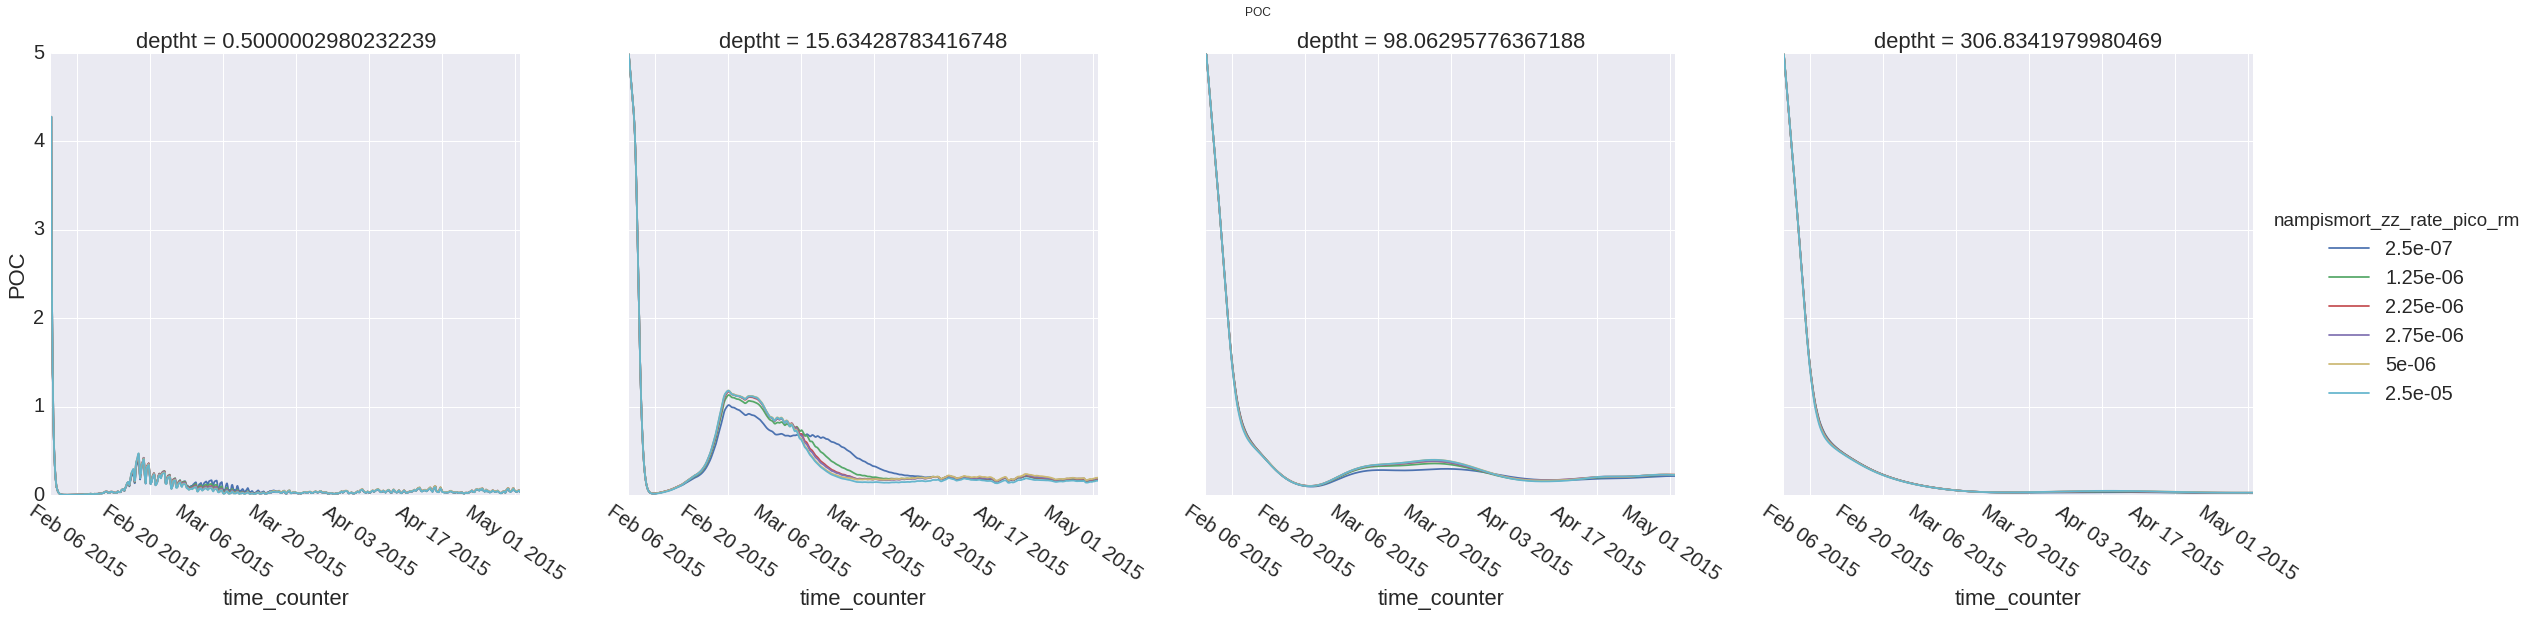

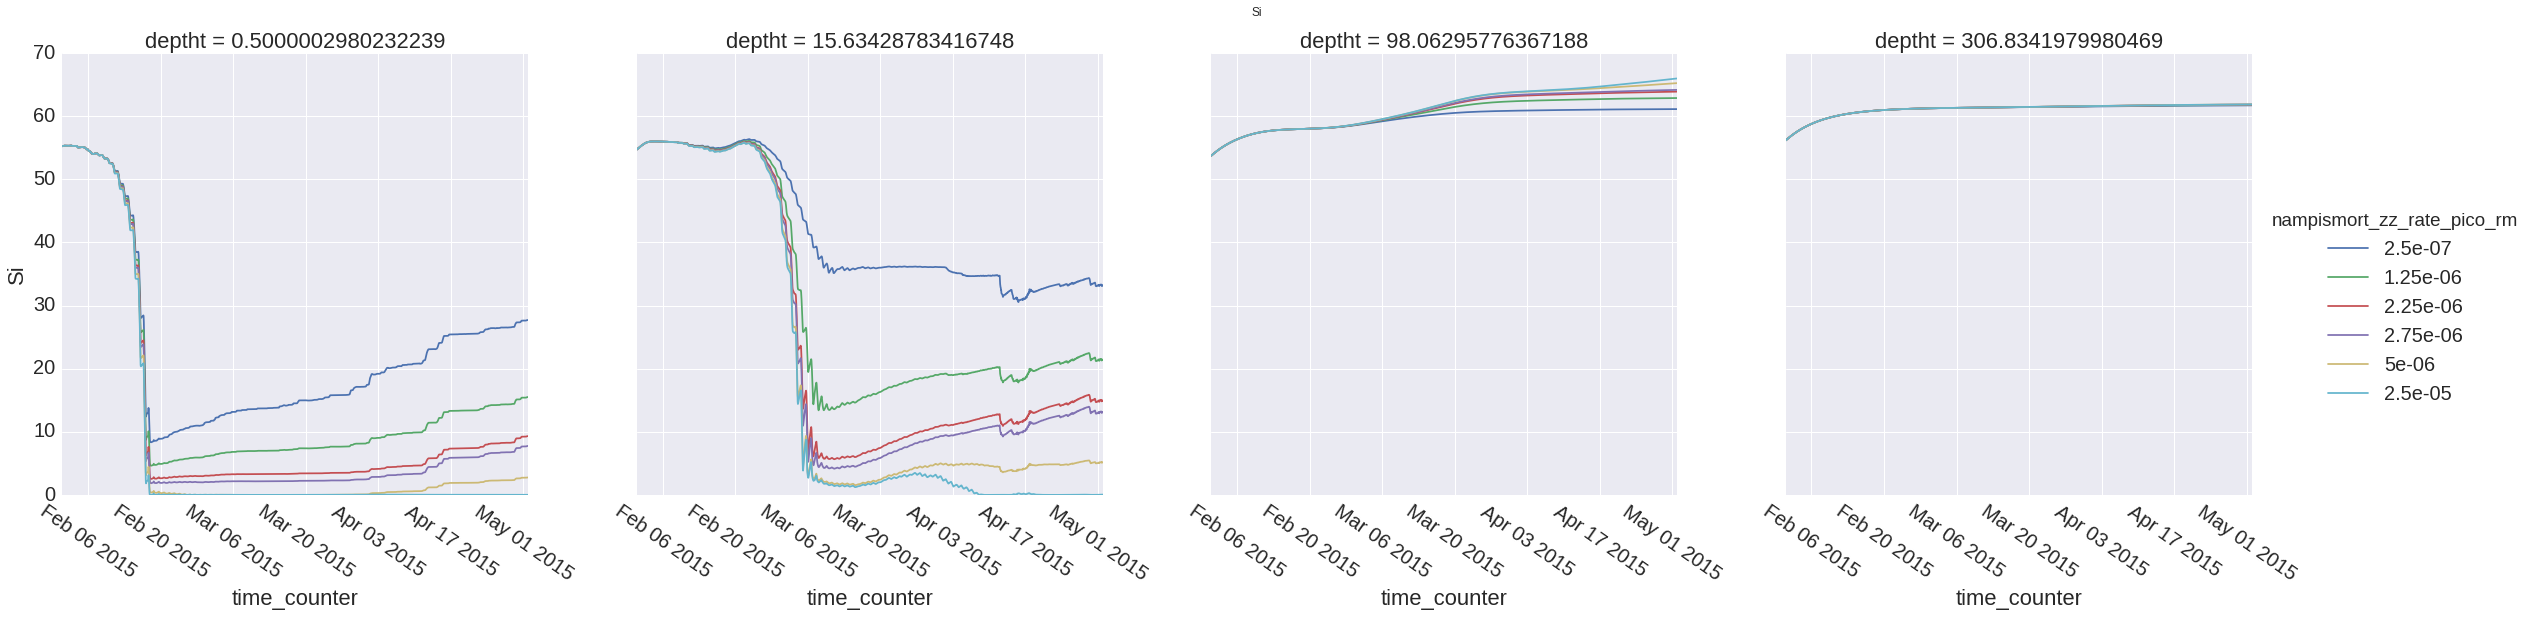

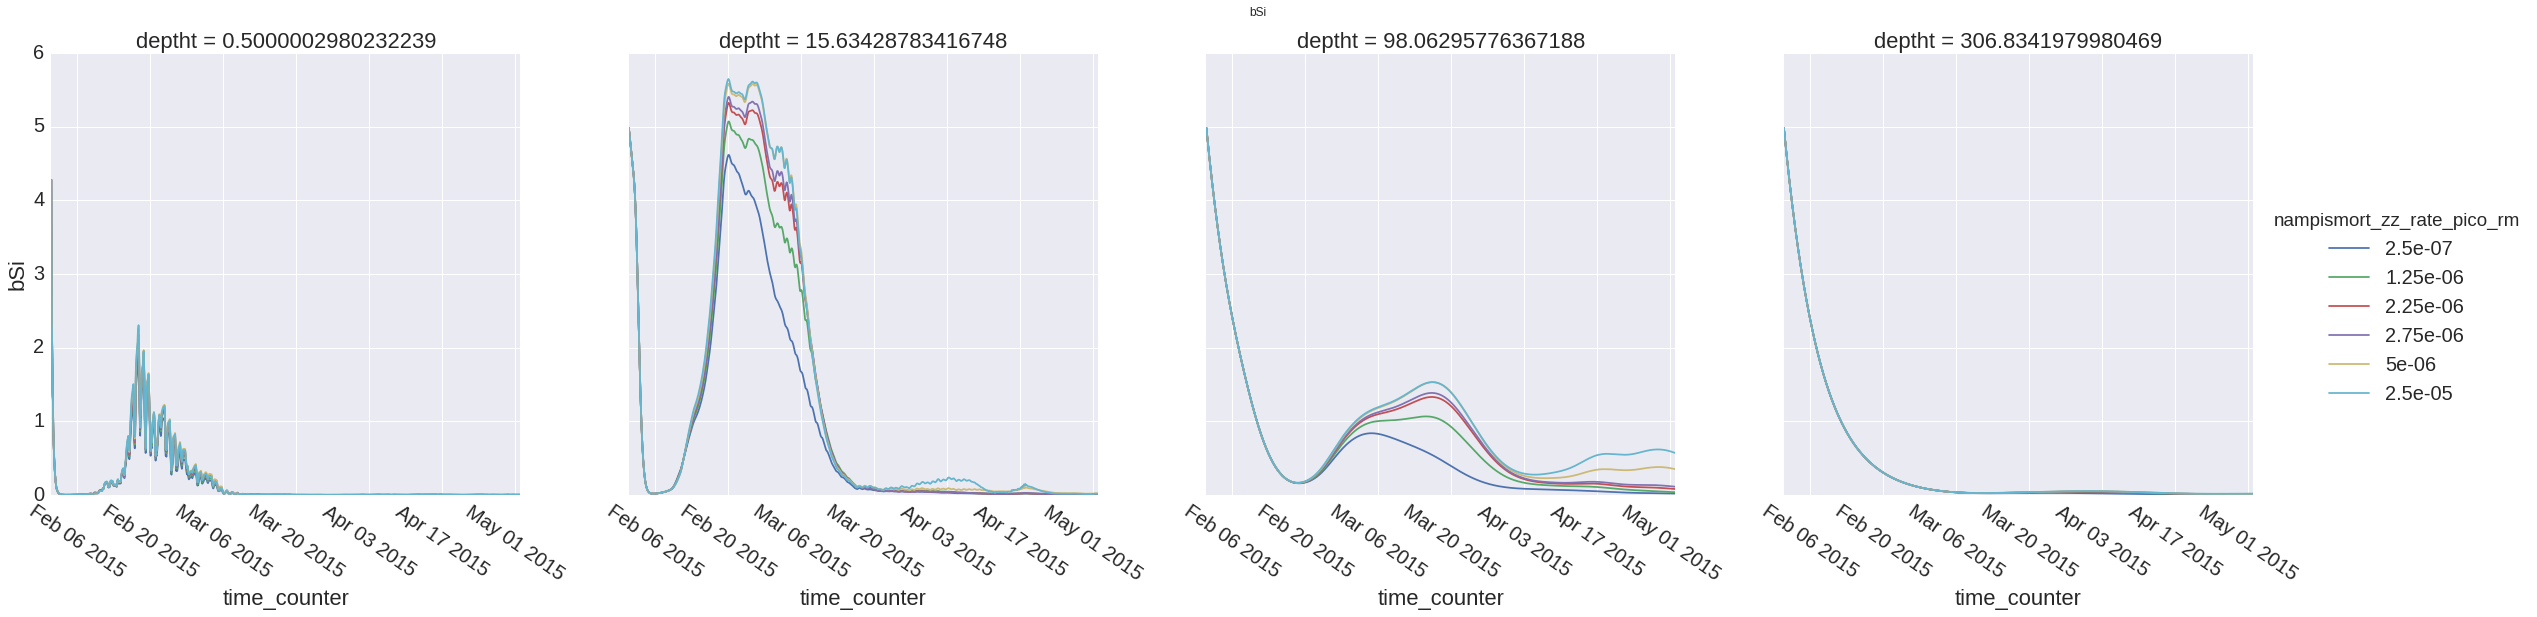

In [12]:
sns.set(font_scale = 2)
depth_vals = (df_subset['deptht'].unique())[[0,15,26,34]]

print(depth_vals)
for var in plot_vars:
    fg = sns.FacetGrid(data=df_subset.query("deptht in @depth_vals"), hue=param_name,col = "deptht",size =8)
    fg.map(plt.plot, 'time_counter', var).add_legend()
    fg.set_xticklabels(rotation=-35)
    plt.subplots_adjust(top=0.9)
    fg.fig.suptitle(var)
sns.set(font_scale = 1)